Use GAN and conditional-GAN to generate fashion-MNIST images

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 12531187.30it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 202519.79it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3766701.27it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4971742.34it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



# GAN

In [3]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))


In [5]:
num_epochs = 50
batch_size = 64
learning_rate = 0.0002
latent_dim = 100

criterion = nn.BCELoss()

generator = Generator()
discriminator = Discriminator()

optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate)
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    epoch_d_loss, epoch_g_loss = 0, 0

    for i, (imgs, _) in enumerate(train_loader):
        valid = torch.ones(imgs.size(0), 1, device=imgs.device)
        fake = torch.zeros(imgs.size(0), 1, device=imgs.device)

        optimizer_D.zero_grad()

        real_loss = criterion(discriminator(imgs), valid)
        real_loss.backward()

        z = torch.randn(imgs.size(0), latent_dim, device=imgs.device)
        gen_imgs = generator(z)

        fake_loss = criterion(discriminator(gen_imgs.detach()), fake)
        fake_loss.backward()

        optimizer_D.step()
        optimizer_G.zero_grad()

        g_loss = criterion(discriminator(gen_imgs), valid)
        g_loss.backward()

        optimizer_G.step()

        epoch_d_loss += real_loss.item() + fake_loss.item()
        epoch_g_loss += g_loss.item()

    print(f"Epoch {epoch} - Discriminator Loss: {epoch_d_loss / len(train_loader)}, Generator Loss: {epoch_g_loss / len(train_loader)}")


Epoch 0 - Discriminator Loss: 0.6842120549460845, Generator Loss: 2.784383148653929
Epoch 1 - Discriminator Loss: 0.6835302580902571, Generator Loss: 2.6666689065219495
Epoch 2 - Discriminator Loss: 0.7150559128045655, Generator Loss: 2.3492222244043086
Epoch 3 - Discriminator Loss: 0.856458030815826, Generator Loss: 2.0318074546643157
Epoch 4 - Discriminator Loss: 0.8524136023798476, Generator Loss: 1.8343750013471412
Epoch 5 - Discriminator Loss: 0.9230376078979547, Generator Loss: 1.6414569812034494
Epoch 6 - Discriminator Loss: 1.015052789770591, Generator Loss: 1.52998869429265
Epoch 7 - Discriminator Loss: 0.9844811354428212, Generator Loss: 1.4871385298303958
Epoch 8 - Discriminator Loss: 0.9949269886654831, Generator Loss: 1.5296365646665284
Epoch 9 - Discriminator Loss: 1.006231735796054, Generator Loss: 1.4498188930279665
Epoch 10 - Discriminator Loss: 1.0101753872658399, Generator Loss: 1.471389212206737
Epoch 11 - Discriminator Loss: 1.011978830451142, Generator Loss: 1.465

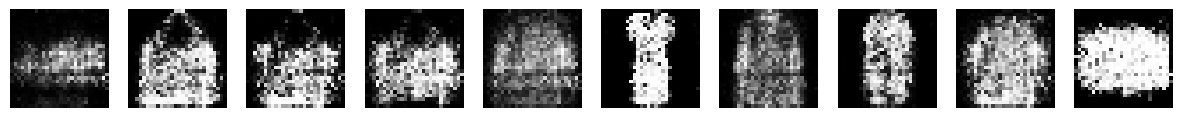

In [8]:
generator.eval()

import matplotlib.pyplot as plt
import numpy as np

def generate_images(generator, num_images):
    z = torch.randn(num_images, 100)

    with torch.no_grad():
        generated_images = generator(z).cpu()

    return generated_images

num_images = 10

generated_images = generate_images(generator, num_images)

fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
for i in range(num_images):
    axs[i].imshow(generated_images[i].squeeze(0), cmap='gray')
    axs[i].axis('off')
plt.show()


# cGAN

In [9]:
class ConditionalGenerator(nn.Module):
    def __init__(self):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        return self.model(x).view(-1, 1, 28, 28)

class ConditionalDiscriminator(nn.Module):
    def __init__(self):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(10, 10)

        self.model = nn.Sequential(
            nn.Linear(794, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        c = self.label_emb(labels)
        x = torch.cat([img.view(img.size(0), -1), c], 1)
        return self.model(x)

In [12]:
num_epochs = 50
latent_dim = 100

generator = ConditionalGenerator()
discriminator = ConditionalDiscriminator()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

for epoch in range(num_epochs):
    epoch_d_loss, epoch_g_loss = 0.0, 0.0

    for i, (imgs, labels) in enumerate(train_loader):
        real = torch.ones(imgs.size(0), 1, device=imgs.device)
        fake = torch.zeros(imgs.size(0), 1, device=imgs.device)

        optimizer_D.zero_grad()

        real_loss = criterion(discriminator(imgs, labels), real)
        real_loss.backward()

        z = torch.randn(imgs.size(0), latent_dim, device=imgs.device)
        fake_labels = torch.randint(0, 10, (imgs.size(0),), device=imgs.device)
        fake_imgs = generator(z, fake_labels)

        fake_loss = criterion(discriminator(fake_imgs.detach(), fake_labels), fake)
        fake_loss.backward()

        optimizer_D.step()

        optimizer_G.zero_grad()

        g_loss = criterion(discriminator(fake_imgs, fake_labels), real)
        g_loss.backward()

        optimizer_G.step()

        epoch_d_loss += (real_loss.item() + fake_loss.item())
        epoch_g_loss += g_loss.item()

    avg_d_loss = epoch_d_loss / len(train_loader)
    avg_g_loss = epoch_g_loss / len(train_loader)
    print(f"Epoch {epoch} - Discriminator Loss: {avg_d_loss}, Generator Loss: {avg_g_loss}")


Epoch 0 - Discriminator Loss: 0.7151110530870635, Generator Loss: 2.349897623189223
Epoch 1 - Discriminator Loss: 0.34132330532102334, Generator Loss: 4.802749971845257
Epoch 2 - Discriminator Loss: 0.4895192838327558, Generator Loss: 3.9801747138057944
Epoch 3 - Discriminator Loss: 0.5293651348524002, Generator Loss: 3.581973212105887
Epoch 4 - Discriminator Loss: 0.5693137105316051, Generator Loss: 3.332770964484225
Epoch 5 - Discriminator Loss: 0.5777084266008344, Generator Loss: 3.214993958407119
Epoch 6 - Discriminator Loss: 0.7067649013626931, Generator Loss: 2.5297574456820864
Epoch 7 - Discriminator Loss: 0.8344827008876465, Generator Loss: 2.2075742880926965
Epoch 8 - Discriminator Loss: 0.8056211986584958, Generator Loss: 2.1998088308997246
Epoch 9 - Discriminator Loss: 0.9005436966541225, Generator Loss: 1.9906701598086083
Epoch 10 - Discriminator Loss: 0.9539797951671869, Generator Loss: 1.7991405689894264
Epoch 11 - Discriminator Loss: 0.9659459278114569, Generator Loss: 1

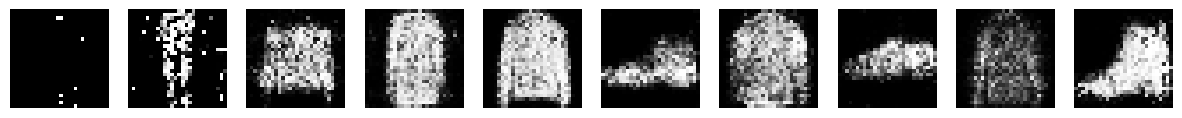

In [14]:
generator.eval()
import matplotlib.pyplot as plt
import numpy as np

def generate_images(generator, num_images, labels):
    z = torch.randn(num_images, latent_dim)

    with torch.no_grad():
        generated_images = generator(z, labels).cpu()

    return generated_images

num_images = 10
labels = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

generated_images = generate_images(generator, num_images, labels)

fig, axs = plt.subplots(1, num_images, figsize=(15, 15))
for i in range(num_images):
    axs[i].imshow(generated_images[i].squeeze(0), cmap='gray')
    axs[i].axis('off')
plt.show()
